In [15]:
import numpy as np
from scipy.optimize import curve_fit
import torch
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
from tqdm import trange
import matplotlib.pyplot as plt


# Введение
В этом блокноте будет реализован новый подход к написанию нейросети. тестовая версия дала хороший результат, поэтому сделаем ее по человечески, вся информайия содержится в разности уровня, амплитуды и фазы сигналов (два синуса на 50 Гц), переделаем пространство входов с 2,5к до 48!

In [3]:
rel_path = '../Dataset/'

A_ref = np.loadtxt(f'{rel_path}RESULT0/Inductance_ALIJ.dat', skiprows=1, dtype=float)
PN_ref = np.loadtxt(f'{rel_path}RESULT0/ProbeVoltagePN.dat', skiprows=1, dtype=float, usecols=np.arange(1, 9))
PT_ref = np.loadtxt(f'{rel_path}RESULT0/ProbeVoltagePT.dat', skiprows=1, dtype=float, usecols=np.arange(1, 9))

A = []
PN = []
PT = []
for i in range(1000):
    A.append(np.loadtxt(f"{rel_path}RESULT1/A{i}.dat", skiprows=1, dtype=float))
    PN.append(np.loadtxt(f"{rel_path}RESULT1/PN{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9)))
    PT.append(np.loadtxt(f"{rel_path}RESULT1/PT{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9)))


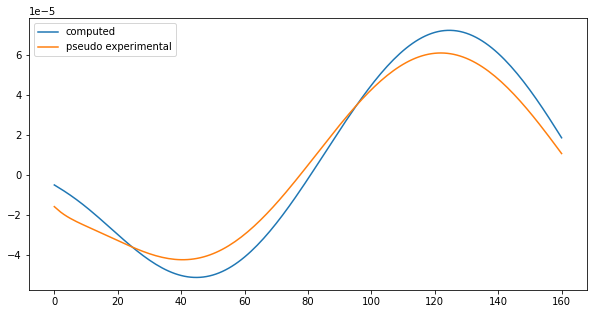

In [132]:
y_ref = PN_ref[:,0]
y_comp = PN[100][:,0]

plt.figure(figsize=(10,5))
plt.plot(y_ref, label='computed')
plt.plot(y_comp, label='pseudo experimental')
plt.legend()

p_comp=[-6.32006531e-05 -1.67948134e-01  8.09578263e-06]
p_ref= [-6.21753112e-05 -1.02878043e-01  7.97677044e-06]


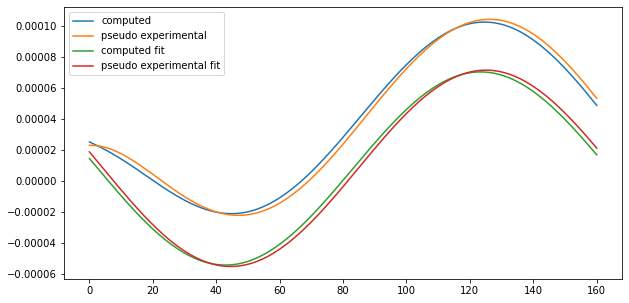

In [86]:
def fit_sine(x, Amp, phase, shift):
    return shift + Amp*np.sin(x + phase)
x = np.arange(len(y_comp))/len(y_comp)*2*np.pi

p_comp, _ = curve_fit(fit_sine, x, y_comp)
p_ref , _ = curve_fit(fit_sine, x, y_ref)

print(f"p_comp={p_comp}\np_ref= {p_ref}")
plt.figure(figsize=(10,5))
plt.plot(3e-5+y_ref, label='computed')
plt.plot(3e-5+y_comp, label='pseudo experimental')
plt.plot(fit_sine(x, *p_ref), label='computed fit')
plt.plot(fit_sine(x, *p_comp), label='pseudo experimental fit')
plt.legend()

Вот собственно все обоснование метода, теперь в трех числах храним всю полезную информацию, погнали делать датасеты

In [112]:
data_in = []

x = np.arange(len(y_comp))/len(y_comp)*2*np.pi
def get_fitted(ydata):
    p, _ = curve_fit(fit_sine, x, ydata, 
                        bounds=((0,-np.pi, 0), (1, np.pi, 1)))
    return np.array(p)

p_pn_ref = []
p_pt_ref = []

for i in trange(PN_ref.shape[1]):
    p_pn_ref.append(get_fitted(PN_ref[:, i]))
    p_pt_ref.append(get_fitted(PT_ref[:, i]))

for i in trange(len(PN)):
    tmp = []
    pn = PN[i]
    pt = PT[i]
    for i in range(pn.shape[1]):
        tmp.append(get_fitted(pn[:, i]) - p_pn_ref[i])
        tmp.append(get_fitted(pt[:, i]) - p_pt_ref[i])
    
    data_in.append(tmp)

data_in = np.array(data_in)
print(f"shape = {data_in.shape}\nbefore normalization first element\n{data_in[0]}")

# two ways of normalization input data
# i prefered the first but will keep both
# becouse it provides dataset with not "all correct" normalisation

if True:
    in_mean = data_in.mean(axis=(0, 1))
    in_std = data_in.std(axis=(0, 1))
    for i in range(data_in.shape[2]):
        data_in[:,:,i] = (data_in[:,:,i]-in_mean[i])/in_std[i]
    print(f"input mean = {in_mean}, std = {in_std}\nFirst elem now\n{data_in[0]}")
    print(f"But total std={data_in.std()}")
else:
    in_mean = data_in.mean()
    in_std = data_in.std()
    data_in = (data_in-in_mean)/in_std
    print(f"input mean = {in_mean}, std = {in_std}\nFirst elem now\n{data_in[0]}")

100%|██████████| 1000/1000 [01:19<00:00, 12.56it/s]

shape = (1000, 16, 3)
before normalization first element
[[-2.64581763e-07 -5.49099227e-02 -1.51937551e-07]
 [-2.60612359e-06  2.14695103e-01 -2.23047115e-06]
 [ 9.45229823e-06  2.64994822e-02 -1.05597324e-07]
 [-2.41985654e-05 -2.67812157e-02  8.70892515e-07]
 [-8.90446789e-08  8.35241391e-04  9.74853451e-09]
 [ 1.55983960e-05  1.33137349e-02 -3.15595862e-08]
 [ 3.90237733e-06  7.17526354e-02  2.50529248e-08]
 [ 1.55819923e-06 -2.22116618e-01  1.76992068e-06]
 [-3.35327273e-07 -1.08382172e-01  1.44188332e-06]
 [-1.64296899e-07 -5.69542787e-02  3.79555362e-07]
 [-2.11119132e-06  8.68816519e-02  1.42669093e-07]
 [ 2.16414746e-06 -1.03195668e-01  8.14515196e-07]
 [ 5.29200141e-06 -3.75227527e-01 -3.74648999e-07]
 [-1.58920601e-06  5.26452133e-02 -3.39741781e-07]
 [ 1.11978132e-05 -1.39573848e+00 -7.03363585e-06]
 [-3.12420712e-06  1.73548969e-01 -1.07642700e-06]]
input mean = [ 6.01491874e-07 -1.95884552e-01 -2.52459574e-07], std = [9.31449453e-06 8.14062930e-01 2.13245725e-06]
First ele

In [83]:
data_out = []
Delta_A = np.array([(x - A_ref).reshape(-1) for x in A])

# Leave only above diagonal elements
for i in trange(Delta_A.shape[0]):
    D_A = Delta_A
    new = []
    for i in range(12):
        tmp = []
        for j in range(i):
            tmp.append(D_A[i][j])
        if tmp != []:
            for x in tmp:
                new.append(x)

    data_out.append(new)

data_out = np.array(data_out)
print(f"shape = {data_out.shape}, before normalization first element\n{data_out[0]}")

out_mean = data_out.mean()
out_std = data_out.std()
data_out = (data_out-out_mean)/out_std
print(f"output mean={out_mean}, std={out_std}\nAfter normalization first elem\n{data_out[0]}")

100%|██████████| 1000/1000 [00:00<00:00, 30297.13it/s]

shape = (1000, 66), before normalization first element
[0.         0.         0.0244033  0.         0.0215807  0.0056119
 0.         0.0049107  0.0087573  0.0048651  0.         0.0115504
 0.0132554  0.0107227  0.0133511  0.         0.0005262  0.0088143
 0.02578    0.0077141  0.0248947  0.         0.0045286  0.0043992
 0.0094874  0.0316422  0.0078556  0.017218   0.         0.0060692
 0.0203862  0.0071234  0.0356198  0.0184876  0.010147   0.0140305
 0.         0.0042442  0.0052056  0.002485   0.0332107  0.0261663
 0.0176468  0.0194835  0.0032206  0.         0.0011089  0.0004674
 0.0188519  0.0311742  0.0088689  0.0076853  0.0065664  0.0101313
 0.0168879  0.         0.0240212  0.0127166  0.0127552  0.0101682
 0.0066162  0.0187706  0.0219346  0.0112301  0.0022841  0.00712276]
output mean=0.010829652424242416, std=0.009459180304991368
After normalization first elem
[-1.14488276 -1.14488276  1.4349708  -1.14488276  1.13657286 -0.55160725
 -1.14488276 -0.62573629 -0.21908372 -0.63055701 -1.14

Датасеты готовы переходим к организации нейросети, будем использовать самую простую архитектуру Feed Forward (полносвязная сеть)

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#reshaping data_in (1000, 16, 3) -> (1000, 48) 
data_in = data_in.reshape((data_in.shape[0], data_in.shape[1]*data_in.shape[2]))
U_train, U_test, A_train, A_test = train_test_split(
                                    data_in, data_out, test_size=0.2)

U_train = torch.from_numpy(U_train).to(dtype=torch.float32).to(device)
U_test = torch.from_numpy(U_test).to(dtype=torch.float32).to(device)
A_train = torch.from_numpy(A_train).to(dtype=torch.float32).to(device)
A_test = torch.from_numpy(np.array(A_test)).to(dtype=torch.float32).to(device)

In [162]:
hidden = 100
class Net(nn.Module):
    def __init__(self, device, U_shape, A_shape):
        super(Net, self).__init__()

        self.input_shape = U_shape
        self.output_shape = A_shape
        self.fcFF = nn.Sequential(
            nn.Linear(self.input_shape, hidden),
            nn.GELU(),
            nn.Linear(hidden, 2*hidden),
            nn.GELU(),
            nn.Linear(2*hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, self.output_shape)
        ).to(device)

    def forward(self, U):
        return self.fcFF(U)


def compute_loss(A, A_true):
    return torch.sum((A- A_true)**2)

def accuracy(A, A_true):
    acc_min = 1e-2
    return torch.sum(torch.abs(A - A_true) < acc_min)/torch.prod(torch.tensor(A.shape))

def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

net = Net(device, data_in.shape[1], data_out.shape[1])
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, amsgrad=False, weight_decay=0)
net

Net(
  (fcFF): Sequential(
    (0): Linear(in_features=48, out_features=100, bias=True)
    (1): GELU()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): GELU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): GELU()
    (6): Linear(in_features=100, out_features=66, bias=True)
  )
)

100%|██████████| 10000/10000 [02:20<00:00, 71.39it/s]


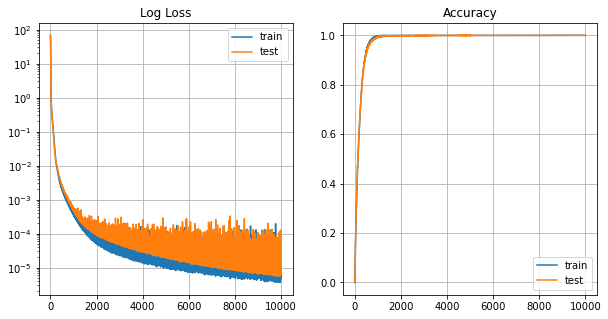

In [163]:
L_train, L_test, acc_train, acc_test = [], [], [], []
L_test = []
batch_size = 100

for epoch in trange(10000):
    net.train(True)
    l = 0.0
    acc = 0.0

    for U_t, A_t in iterate_minibatches(U_train, A_train, batch_size):
        A_h = net.forward(U_t)
        loss = compute_loss(A_h, A_t)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        l += loss.detach().cpu().numpy()
        acc += accuracy(A_h, A_t).cpu().numpy()
            

    L_train.append(l/A_train.shape[0])
    acc_train.append(acc/(U_train.shape[0]/batch_size))

    net.train(False)
    A_h = net.forward(U_test)
    with torch.no_grad():
        L = compute_loss(A_h, A_test).cpu().numpy()
    L_test.append(L/A_test.shape[0])
    acc_test.append(accuracy(A_h, A_test).cpu().numpy())

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

ax1.plot(L_train, label='train')
ax1.plot(L_test, label='test')
ax1.grid()
ax1.set_title('Log Loss')
ax1.legend()
ax1.set_yscale('log')

ax2.plot(acc_train, label='train')
ax2.plot(acc_test, label='test')
ax2.grid()
ax2.set_title('Accuracy')
ax2.legend()

plt.show()

In [128]:
#save result
torch.save(net.state_dict(), r'dump_configurations\light_net_500.torch')

А теперь вернемся к начальному примеру и попробуем продемонстрировать результат работы сети

In [165]:
comp = []
for i in range(8):
    comp.append(p_pn_ref[i])
    comp.append(p_pt_ref[i])
comp = np.array(comp)

exp = data_in[100].reshape((16, 3))*in_std + in_mean + comp

for_net = (exp - comp - in_mean)/in_std
for_show = torch.from_numpy(for_net.reshape((48))).to(dtype=torch.float32).to(device)
net_pred_A = net(for_show)*out_std + out_mean

net_pred_A

tensor([-1.3133e-05, -1.4243e-05,  2.4422e-02, -1.2974e-05,  2.1595e-02,
         5.6057e-03, -1.6334e-05,  4.9002e-03,  8.7533e-03,  4.8548e-03,
        -1.7115e-05,  1.1551e-02,  1.3265e-02,  1.0719e-02,  1.3352e-02,
        -1.6398e-05,  5.1298e-04,  8.8116e-03,  2.5801e-02,  7.7075e-03,
         2.4914e-02, -1.6754e-05,  4.5161e-03,  4.3874e-03,  9.4895e-03,
         3.1667e-02,  7.8494e-03,  1.7228e-02, -1.3439e-05,  6.0606e-03,
         2.0398e-02,  7.1154e-03,  3.5656e-02,  1.8494e-02,  1.0141e-02,
         1.4037e-02, -1.1558e-05,  4.2281e-03,  5.1931e-03,  2.4725e-03,
         3.3246e-02,  2.6183e-02,  1.7655e-02,  1.9495e-02,  3.2035e-03,
        -1.6405e-05,  1.0989e-03,  4.4940e-04,  1.8863e-02,  3.1199e-02,
         8.8675e-03,  7.6823e-03,  6.5592e-03,  1.0131e-02,  1.6897e-02,
        -1.3073e-05,  2.4037e-02,  1.2724e-02,  1.2760e-02,  1.0165e-02,
         6.6112e-03,  1.8784e-02,  2.1949e-02,  1.1231e-02,  2.2710e-03,
         7.1180e-03], device='cuda:0', grad_fn=<Add

In [164]:
net(for_show), data_out[100]

(tensor([-1.1463, -1.1464,  1.4369, -1.1463,  1.1381, -0.5523, -1.1466, -0.6268,
         -0.2195, -0.6316, -1.1467,  0.0762,  0.2574, -0.0117,  0.2667, -1.1466,
         -1.0907, -0.2133,  1.5828, -0.3301,  1.4889, -1.1467, -0.6675, -0.6811,
         -0.1417,  2.2028, -0.3151,  0.6764, -1.1463, -0.5042,  1.0115, -0.3927,
          2.6246,  0.8103, -0.0729,  0.3391, -1.1461, -0.6979, -0.5959, -0.8835,
          2.3698,  1.6232,  0.7215,  0.9160, -0.8062, -1.1466, -1.0287, -1.0974,
          0.8492,  2.1534, -0.2074, -0.3327, -0.4515, -0.0739,  0.6414, -1.1463,
          1.3962,  0.2002,  0.2041, -0.0703, -0.4460,  0.8409,  1.1755,  0.0424,
         -0.9048, -0.3924], device='cuda:0', grad_fn=<AddBackward0>),
 array([-1.14488276, -1.14488276,  1.4349708 , -1.14488276,  1.13657286,
        -0.55160725, -1.14488276, -0.62573629, -0.21908372, -0.63055701,
        -1.14488276,  0.07619556,  0.25644374, -0.01130673,  0.2665609 ,
        -1.14488276, -1.08925426, -0.21305783,  1.58051196, -0.

In [166]:
_tmp = np.zeros((12, 12))
idx = 0
for i in range(12):
    for j in range(i):
        _tmp[i, j] = net_pred_A[idx]
        _tmp[j, i] = net_pred_A[idx]
        idx += 1

_tmp = A_ref + _tmp
np.savetxt('A.txt', _tmp, fmt='  %11.6e')

Теперь отправляем полученный файл А.txt в код и посмотрим что он выдаст

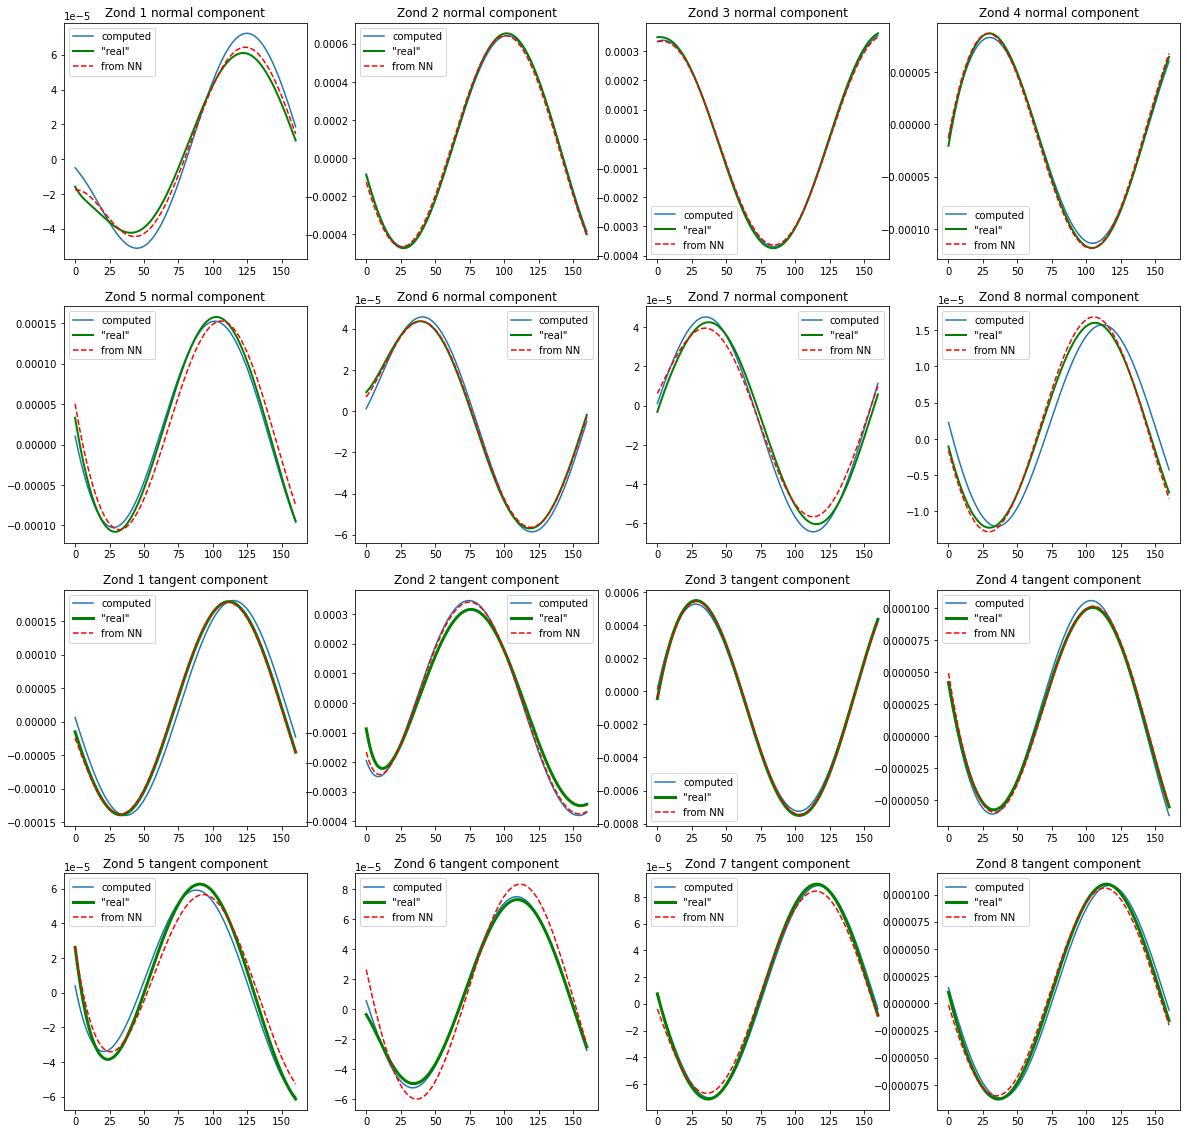

In [167]:
net_PN = np.loadtxt(f"{rel_path}RESULT1/PN{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9))
net_PT = np.loadtxt(f"{rel_path}RESULT1/PT{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9))
ig, ax = plt.subplots(4, 4, figsize=(20, 20))


for i in range(2):
    for j in range(4):
        ax[i][j].set_title(f'Zond {1+4*i+j} normal component')
        ax[i][j].plot(PN_ref[:, 4*i+j], label='computed')
        ax[i][j].plot(PN[100][:, 4*i+j], 'g', label = '"real"', linewidth=2)
        ax[i][j].plot(net_PN[:, 4*i+j], 'r--', label='from NN')
        ax[i][j].legend()
        
        
        ax[i+2][j].set_title(f'Zond {1+4*i+j} tangent component')
        ax[i+2][j].plot(PT_ref[:, 4*i+j], label='computed')
        ax[i+2][j].plot(PT[100][:, 4*i+j], 'g', label = '"real"', linewidth=3)
        ax[i+2][j].plot(net_PT[:, 4*i+j], 'r--', label='from NN')
        ax[i+2][j].legend()
